### Import modules

In [3]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [4]:
BASE_DIR = '/icgdrive/MyDrive/dataset'
WORKING_DIR = '/icgdrive/MyDrive'

### Extract Image Features

In [5]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 [==============================] - 24s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [6]:
!mkdir icgdrive

In [7]:
from google.colab import drive
drive.mount('/icgdrive')

Mounted at /icgdrive


In [9]:
features = {}
directory = os.path.join(BASE_DIR,'Images')
for image in tqdm(os.listdir(directory)):
  imagepath = directory + '/' + image
  img = load_img(imagepath, target_size=(224,224))
  img = img_to_array(img)
  img = img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
  img = preprocess_input(img)
  feature = model.predict(img, verbose=0)
  img_id = image.split('.')[0]
  features[img_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

### Save features

In [13]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'MLicg_features.pkl'), 'wb'))

In [14]:
with open(os.path.join(WORKING_DIR, 'MLicg_features.pkl'), 'rb') as f:
    features = pickle.load(f)

### Load the captions

In [15]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
  next(f)
  captions_doc = f.read()

In [16]:
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    img_id, caption = tokens[0], tokens[1:]
    img_id = img_id.split('.')[0]
    caption = " ".join(caption)
    if img_id not in mapping:
        mapping[img_id] = []
    # store the caption
    mapping[img_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [17]:
len(mapping)

8091

### Preproces Text

In [10]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      caption = captions[i]
      caption = caption.lower()
      caption = caption.replace('[^A-Za-z]','')
      caption = caption.replace('\s+', ' ')
      caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
      captions[i] = caption

In [18]:
mapping['1009434119_febe49276a']


['A black and white dog is running in a grassy garden surrounded by a white fence .',
 'A black and white dog is running through the grass .',
 'A Boston terrier is running in the grass .',
 'A Boston Terrier is running on lush green grass in front of a white fence .',
 'A dog runs on the green grass near a wooden fence .']

In [19]:
clean(mapping)

In [20]:
mapping['1009434119_febe49276a']

['startseq black and white dog is running in grassy garden surrounded by white fence endseq',
 'startseq black and white dog is running through the grass endseq',
 'startseq boston terrier is running in the grass endseq',
 'startseq boston terrier is running on lush green grass in front of white fence endseq',
 'startseq dog runs on the green grass near wooden fence endseq']

In [21]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [22]:
len(all_captions)

40455

In [23]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [25]:
with open(WORKING_DIR+'/MLicg_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
vocab_size


8485

In [27]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

### Train Test Split

In [28]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [29]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

### Model Creation

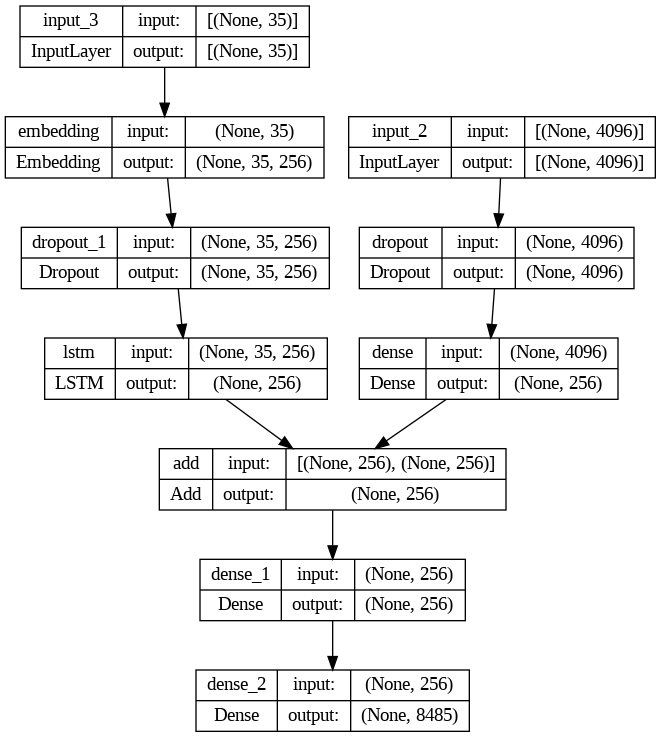

In [30]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


decoder1 = add([fe2,se3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1,inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [31]:
len(train)

7281

In [32]:
len(test)

810

In [33]:
epochs = 28
batch_size = 8
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

910/910 [==============================] - 150s 165ms/step - loss: 1.9947


In [34]:
model.save(WORKING_DIR+'/MLicg_model.h5')

In [35]:
model = load_model(WORKING_DIR+'/MLicg_model.h5')

### Generate captions

In [36]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [37]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [38]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.515462
BLEU-2: 0.288135


## Results

In [39]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs playing with each other on the grass endseq


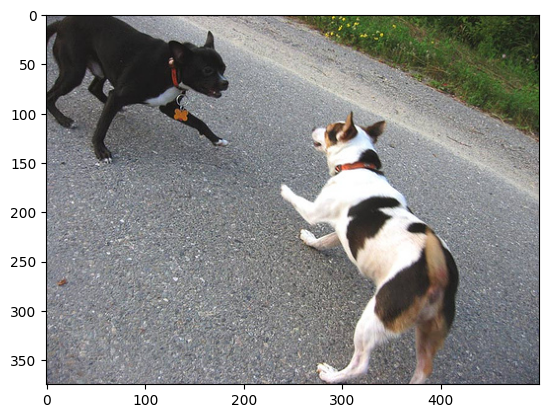

In [40]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq distant person is climbing up very sheer mountain endseq
startseq panoramic distance view of rock climber going up steep mountain wall endseq
startseq person rock climbing endseq
startseq there is person scaling very steep rock wall endseq
startseq this person is climbing the side of mountain endseq
--------------------Predicted--------------------
startseq man is climbing up rock on snowy hillside endseq


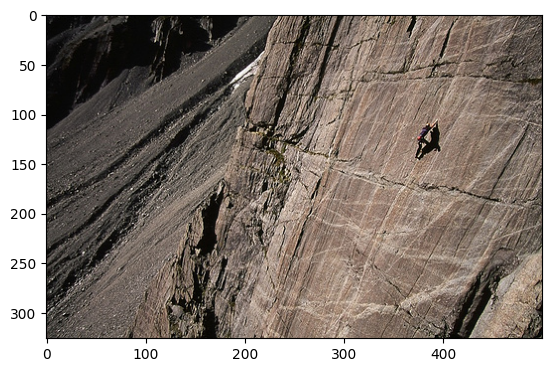

In [46]:
generate_caption(test[100]+".jpg")

---------------------Actual---------------------
startseq "a big black dog is walking along the water 's edge ." endseq
startseq black dog and its reflection are seen near pond ringed by dry foliage endseq
startseq black dog is walking beside water in the woods endseq
startseq black dog walks along marsh 's edge endseq
startseq dog is walking near body of water endseq
--------------------Predicted--------------------
startseq dog is walking in the water endseq


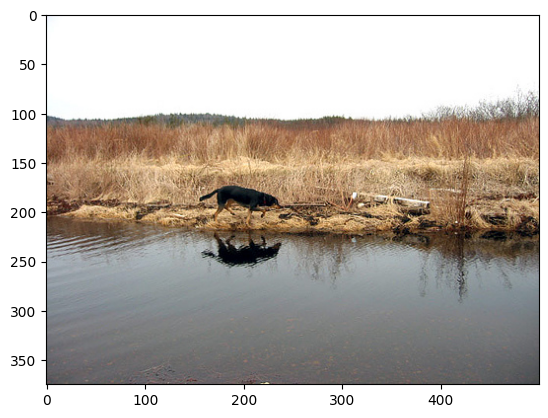

In [47]:
generate_caption(test[88]+".jpg")


---------------------Actual---------------------
startseq group of people walk through shopping mall endseq
startseq many people walk through the store endseq
startseq people browse in store endseq
startseq people strolling through an indoor market endseq
startseq the shoppers are walking in store endseq
--------------------Predicted--------------------
startseq people shop for fresh produce at restaurant endseq


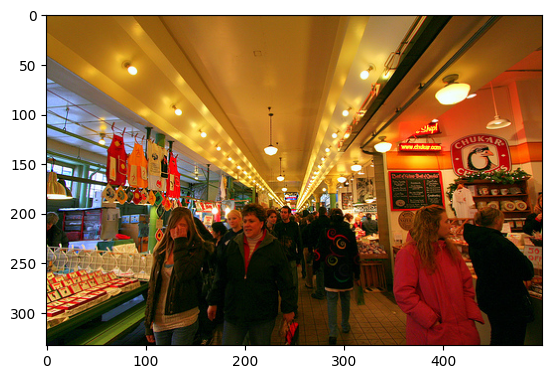

In [51]:
generate_caption(test[14]+".jpg")
